#**Using pure pytorch tensor datastructure to build a 3 layer neural network with ReLU activation function**

In [22]:
import torch
import numpy
import math

In [3]:
#creating 3-d non linear data

n_samples = 200
d = 3
x = torch.FloatTensor(n_samples, d).uniform_(-1, 1)

weights_true = torch.tensor([[5, 1, 6], [1, 6, 1]]).float()
weights_true = torch.transpose(weights_true, 0, 1) #transposing to multiply in the next step
bias_true = torch.tensor([1, 1])

y_true = torch.mm((x ** 2), weights_true) + torch.mm(x, weights_true) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2]), y: torch.Size([200, 2])


Plotting the data

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_3d(x, y, y_pred=None):
  X_embedded = TSNE(n_components=2).fit_transform(x)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y, label='underlying function') 
  if y_pred is not None:
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y_pred, label='our function')
  plt.legend()

Plotting both the labels in y_true

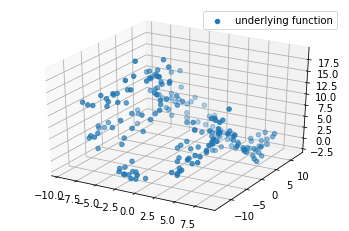

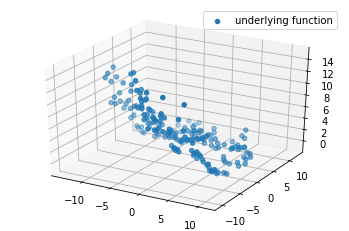

In [7]:
plot_3d(x, y_true[:, 0])
plot_3d(x, y_true[:, 1])

##Specifying all the necessary functions and defining 3 Layer neural network with PyTorch 

###Loss Function

In [17]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

###We are going to use gradient descent to learn the weights and bias that minimize the loss.

In [18]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)

  def __call__(self, x):
    self.x = x
    output = torch.mm(x, self.weights) + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = torch.mm(torch.transpose(self.x,0, 1), gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = torch.mm(gradient, torch.transpose(self.weights, 0, 1))
    return self.x_gradient
  
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

###Adding non-linearity using ReLU

In [19]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = torch.clip(self.input_, 0, None)
    return self.output
  
  def backward(self, output_gradient):
    self.input_gradient = (self.input_ > 0) * output_gradient
    return self.input_gradient

###Defining model class

In [20]:
#Building a 3 Layer Neural Network model. Choosing 10 neurons as the hidden layer neurons. Output is 2

class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden, 10)
    self.relu2 = Relu()
    self.linear3 = Linear(10, 2)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r1= self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    return linear1_gradient
  
  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

###Defining the fit method and training the model

In [27]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

loss = MSE()
model = Model(d, 10)
y_pred = model(x)

fit(x, y_true, model=model, loss=loss, lr=0.01, num_epochs=100)

Epoch 0, loss 29.580842971801758
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 1, loss 22.0974063873291
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 2, loss 14.50024700164795
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 3, loss 9.579795837402344
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 4, loss 8.219805717468262
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 5, loss 8.075738906860352
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 6, loss 8.016096115112305
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 7, loss 7.960984706878662
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 8, loss 7.90839958190918
MSE backward torch.Size([200, 2]) torch.Size([200, 2]) torch.Size([200, 2])
Epoch 9, loss 7.8573389053344

###Plotting both the labels in y_true and y_pred

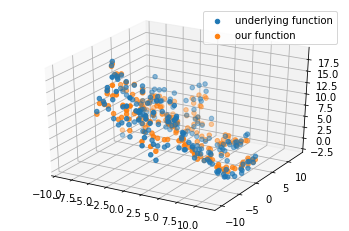

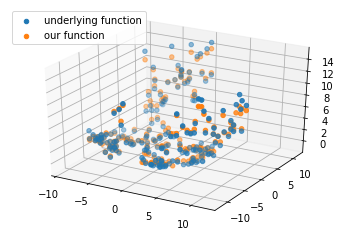

In [28]:
plot_3d(x, y_true[:, 0], model(x)[:, 0])
plot_3d(x, y_true[:, 1], model(x)[:, 1])